In [2]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
# TO USE:
# Uncomment three !pip install lines
# Run this cell ONLY
# Runtime -> Restart session
# Comment three !pip install lines
# Run all

# Andy can push

# Pandas 1.5.3
# Numpy 1.26.3
# Json 2.0.9
# NLTK (Natural Language Toolkit) 3.8.1
# Gensim 4.3.2
# Spacy 3.6.1
# PyLDAvis 3.4.0
# re (removing characters) 2.2.1
# clean from cleantext
# from prompt_toolkit.completion import word_completer
# from pprint import pprint
# import matplotlib.pyplot as plt


%pip install pyLDAvis
%pip install --user -U nltk
%pip install -U spacy
%pip install "pandas==1.5.3"

  Using cached pandas-2.2.1-cp310-cp310-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.1-cp310-cp310-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl.metadata (12 kB)
Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl (10.4 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [3]:
#

import numpy as np
import json
import glob
import nltk
import pandas as pd #to work with csv files

# pd.__version__ = 2.0.0
print(pd.__version__)

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

1.5.3


In [4]:
import os
#The function that loops through the data to check for optimal parameters to input into the LDA model would take over 16 hours to run,
#after a while the runtime disconnects, which makes the progress start from 0.
#so the purpose of this function is to make sure the runtime doesnt disconnect, while training for optimal params to input to lda model.

#def check_and_reconnect_drive():
    #try:
        # Check if Google Drive is still connected
     #   os.listdir('/content/drive')
  #  except:
        # If not, reconnect it
  #      from google.colab import drive
  #      drive.mount('/content/drive', force_remount=True)

# Then call this function every so often in your main script
#check_and_reconnect_drive()

In [5]:
nltk.download('stopwords')

stopwords = stopwords.words("english") #get stopwords from nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#stopwords.extend(['hi', 'anymore', 'years', 'ago', 'almost', 'somehow', 'remember', 'wants', 'either', 'enough', 'much', 'making', 'simple', 'things', 'add', 'actual', 'say', 'etc', 'anything', 'days', 'long', 'another', 'ever', 'yes', 'th', 'ice', 'mightymouse', 'should', 'obviously', 'even', 'lol', 'stuff', 'never', 'old', 'yr', 'bit', 'like', 'aka', 'nonsense', 'ok', 'absolutely', 'op', 'weird', 'ass', 'fully', 'get', 'would', 'definitely', 'especially', 'still', 'else', 'something', 'often', 'kind', 'let', 'lot', 'able', 'non', 'pg', 'nice', 'trad', 'keep', 'massive', 'quickly', 'be', 'common', 'tv', 'fuckin', 'im', 'could', 'also', 'silly', 'ie', 'seem', 'seems', 'fucked'])#Add custom stop words
stopwords.extend(['r/parenting', 'r/roblox', 'get'])#Add reddit paths

In [7]:
def wordcounts(text1):
  fdist1 = FreqDist(text1)
  print(fdist1)
  fdist1.most_common(50)

In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [9]:
def load_data(file):
  data = pd.read_csv(file)
  return data

In [10]:
data = load_data('../Used_Dataset/finalCumulative.csv')
filtered_data = data.drop(columns=['subreddit','date','timestamp'], axis=1)
data = filtered_data.replace('\n', ' ', regex=True)
# data.head(5)

In [11]:
# data[data.text.str.contains('I am a bot')]

In [12]:
import re

data = data.loc[data.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
data['text'] = data['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

data['text'] = data['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\(', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\)', ' ', x))
data['text'] = data['text'].replace(r'&\S+', '', regex=True)
data['text'] = data['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
data['text'] = data['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
data['text'] = data['text'].map(lambda x: re.sub(pattern, ' ', x))
data['text'] = data['text'].map(lambda x: re.sub(' +', ' ', x))

data.shape

(22911, 2)

In [13]:
data.columns

Index(['Unnamed: 0', 'text'], dtype='object')

In [14]:
data.head(5)

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [15]:
data[data.text.str.contains('I am a bot')]

,Unnamed: 0,text


In [16]:
data['text'][51]

"hey i'm not a parent but i have a little brother and i'm consered for him because in most games he plays there's the blox ____ scams i won't actually say the links because people could accidentally click it but i have to remind him every time he plays mom won't let him spend money on there cuz he's too young so he's trying to get free robux "

In [17]:
!pip install clean-text
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [18]:
data = [clean(d, no_emoji=True) for d in data['text']]

In [19]:
data = remove_stopwords(data)

In [20]:
resultx = []
for d in data:
  resultx.append(' '.join(d))

#resultxtokens = resultx.split()


In [21]:
resultx[:5]

['concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss amon

In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
words = [word_tokenize(i) for i in resultx]
words2= [num for elem in words for num in elem]
#words = nltk.tokenize.word_tokenize(resultx)

#wordcounts(words2)
fdist1 = FreqDist(words2)
#print(fdist1)
fdist1.most_common(50)


#>>> # flatten a list using a listcomp with two 'for'
#>>> vec = [[1,2,3], [4,5,6], [7,8,9]]
#>>> [num for elem in vec for num in elem]
#[1, 2, 3, 4, 5, 6, 7, 8, 9]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('game', 6524),
 ('like', 5984),
 ('games', 5246),
 ('kids', 4437),
 ('roblox', 4332),
 ('play', 3403),
 ('time', 3397),
 ('would', 2991),
 ('people', 2948),
 ('one', 2532),
 ('think', 2462),
 ('also', 2443),
 ('money', 2409),
 ('make', 2397),
 ('know', 2375),
 ('good', 2314),
 ('kid', 2313),
 ('even', 2248),
 ('old', 2155),
 ('year', 2033),
 ('really', 2012),
 ('pokemon', 1922),
 ('want', 1867),
 ('much', 1857),
 ('things', 1834),
 ('still', 1804),
 ('something', 1746),
 ('way', 1703),
 ('playing', 1580),
 ('better', 1486),
 ('could', 1458),
 ('let', 1449),
 ('child', 1422),
 ('buy', 1403),
 ('phone', 1401),
 ('see', 1379),
 ('need', 1359),
 ('got', 1343),
 ('go', 1313),
 ('never', 1286),
 ('lot', 1277),
 ('say', 1275),
 ('friends', 1266),
 ('back', 1264),
 ('going', 1260),
 ('thing', 1247),
 ('son', 1240),
 ('well', 1227),
 ('daughter', 1215),
 ('bad', 1210)]

In [23]:
result = []
for d in data:
  result.append(' '.join(d))
# result

In [24]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = filtered_data.review_text_processed.values.tolist()
data_words = list(sent_to_words(result))

# prints the first 30 words of the first tokenized review from the data_words list.
# print(data_words[:1][0][:30])

In [25]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [26]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# # NO BIGRAMS
# !python -m spacy download en_core_web_sm
# import spacy

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [28]:
# BIGRAMS DATA
!python -m spacy download en_core_web_sm
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for unigram
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram
# data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.8 MB 1.6 MB/s eta 0:00:08
      --------------------------------------- 0.3/12.8 MB 1.8 MB/s eta 0:00:07
     - -------------------------------------- 0.5/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 3.4 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 3.2 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.8 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 3.6 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.8 MB/s eta 0:00:03
     ------ --------------------------------- 1.9/12.8 MB 3.7 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 

In [29]:
print(type(data_lemmatized))

<class 'list'>


Remove Duplicate Words (TO REMOVE)

In [30]:
# from collections import Counter
# def unique(d):
#   UniqW = Counter(d)
#   result = [*UniqW]
#   # corpus = ' '.join(UniqW.keys())
#   return result

In [31]:
# single_data = []
# for d in data_lemmatized:
#   for word in d:
#     single_data.append(word)

In [32]:
# unique_data = [unique(d) for d in data_lemmatized]
# # unique_data = unique(single_data)

In [33]:
# print(type(unique_data))

In [34]:
# unique_data

In [35]:
from prompt_toolkit.completion import word_completer
id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(bag_of_words)

corpus = []
for text in data_lemmatized:
  new = id2word.doc2bow(text)
  corpus.append(new)

print(corpus[0])

print(data_words[:1][0][:30])
# print(word_completer)

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 2), (12, 7), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 2), (31, 1), (32, 10), (33, 4), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 4), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 4), (59, 1), (60, 1), (61, 5), (62, 3), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 5), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 3), (92, 2), (93, 1), (94, 1), (95, 3), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 2), (105, 3), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [36]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.01,
                                       eta=0.61)

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056858 -0.205850       1        1  45.460814
3      0.136407 -0.045977       2        1  27.353247
1     -0.096871 -0.162289       3        1  23.509977
4     -0.126572  0.177734       4        1   2.377097
0      0.030178  0.236382       5        1   1.298865, topic_info=          Term          Freq         Total Category  logprob  loglift
32        game  10199.000000  10199.000000  Default  30.0000  30.0000
156      money   2159.000000   2159.000000  Default  29.0000  29.0000
40         kid   5661.000000   5661.000000  Default  28.0000  28.0000
74      roblox   2533.000000   2533.000000  Default  27.0000  27.0000
887    pokemon   1597.000000   1597.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
118    exactly      7.467341    242.430487   Topic5  -6.6151   0.8635
2148  downvote      6.614608     61.312687   Topic5  -6.7363   2.1170
177          s      7.194427    223.675751   Topic5  -6.6523   0.9068
2603       dog      6.766528     89.521169   Topic5  -6.7136   1.7612
1670      wear      6.726072    149.891571   Topic5  -6.7196   1.2398

[389 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
468        2  0.979926      aaa
4244       1  0.254711  abusive
4244       2  0.063678  abusive
4244       3  0.254711  abusive
4244       5  0.445744  abusive
...      ...       ...      ...
569        2  0.002487  youtube
569        3  0.099480  youtube
569        4  0.002487  youtube
15146      2  0.199418    youuu
15146      5  0.598253    youuu

[1079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])

In [38]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"makeup" + 0.008*"lol" + 0.006*"reddit" + 0.004*"woman" + '
  '0.003*"inner_beauty" + 0.003*"post" + 0.003*"outer_beauty" + 0.003*"man" + '
  '0.002*"comment" + 0.002*"stupid"'),
 (1,
  '0.018*"money" + 0.015*"kid" + 0.013*"phone" + 0.012*"use" + 0.012*"roblox" '
  '+ 0.012*"make" + 0.010*"child" + 0.008*"give" + 0.008*"want" + '
  '0.008*"need"'),
 (2,
  '0.021*"kid" + 0.018*"play" + 0.013*"time" + 0.013*"game" + 0.011*"go" + '
  '0.010*"old" + 0.009*"thing" + 0.009*"think" + 0.009*"want" + 0.009*"year"'),
 (3,
  '0.061*"game" + 0.015*"look" + 0.014*"pokemon" + 0.012*"buy" + 0.012*"play" '
  '+ 0.012*"people" + 0.012*"make" + 0.010*"well" + 0.009*"good" + '
  '0.007*"even"'),
 (4,
  '0.012*"shoe" + 0.008*"minecraft" + 0.008*"roblox" + 0.006*"brand" + '
  '0.006*"pet" + 0.005*"adopt" + 0.005*"pair" + 0.004*"cheap" + '
  '0.004*"converse" + 0.004*"wear"')]


In [39]:
from gensim.models import CoherenceModel

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, corpus=corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5517414161586196


In [98]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

welcome roblox
due massive amounts comments message receiving unfortunately able reply every one best reply comments topic im starting fall behind bit respond asap thank
git gud parenting
poorly purchased kids even read word op seems rotten trend reddit late read op give half baked opinion thanks thanks responding anything bothered actually read thread good day
ok ok ok entitled damn changed damn lot judge book cover
look thread comment lmao
guess read reply seeing replying example commodity accurate comparison would forcing women wear hijabs control roblox job nanny dictate devs lays users
sources
play os runescape
true right kinda speed reading post grasp whole concept talking lol
oh god reddit thing ive read
yeah hold fuck
bot bleep bloop someone linked thread another place reddit robloxcriticism parent complains children hacked follow links please respect rules reddit vote threads info totesmessenger contact message compose totesmessenger
idiot downvoted comments
welcome roblox pla

In [99]:

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

#data_words

In [100]:
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}

#  # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# #A list of alpha values to be tested.
# #It includes a range of values from 0.01 to 1 with a step size of 0.3, as well as two special values: 'symmetric' and 'asymmetric'.
# alpha = list(np.arange(0.01, 1, 0.3))
#  #assumes that all documents are equally likely to be a mixture of topics, resulting in a uniform distribution of topics across documents. So it maps rreviews to each topic evenly
#  #It makes the model assume that every document should have roughly the same proportion of topics.
# # alpha.append('symmetric')
# # #allows for more variability in document-topic proportions.
# # #It doesn't enforce a uniform distribution and allows documents to have varying degrees of focus on different topics.
# alpha.append('asymmetric')

# # # Beta parameter
# # #A list of beta values to be tested. It follows a similar pattern to alpha, including a range and 'symmetric'.
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # # Validation sets:
# # # We have the corpus sets, which contains 2 versions of the corpus, 15% and 20%
# num_of_docs = len(corpus)

# # #A list containing two versions of the 15% corpus, one with 20% of the documents and another with 15% of the documents.
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.20)),
#                gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.15))]

# corpus_title = ['20% Corpus', '15% Corpus']

# #Stores the results of the LDA model with different hyperparameters.
# model_results = {'Validation_Set': [],
#                   'Topics': [],
#                   'Alpha': [],
#                   'Beta': [],
#                   'Coherence': []
#                  }

#  # Can take a long time to run
# if 1 == 1:
#    #progress bar
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#      # iterate through validation corpus sets
#     for i in range(len(corpus_sets)):
#          # iterate through number of topics
#         for k in topics_range:
#              # iterate through alpha values
#             for a in alpha:
#                  # iterare through beta values
#                 for b in beta:
#                      #reconnect the runtime
#                    # check_and_reconnect_drive()
#                      # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
#                                                   k=k, a=a, b=b)

#                      # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a) 
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#      # pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Classes/lda_tuning_results.csv', index=False)
#     pbar.close()

In [101]:
import os


print(os.getcwd())

c:\Users\natas\Documents\GitHub\LDA_Analysis\Code


In [102]:
# if 1==1:
# # pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#     pbar.close()

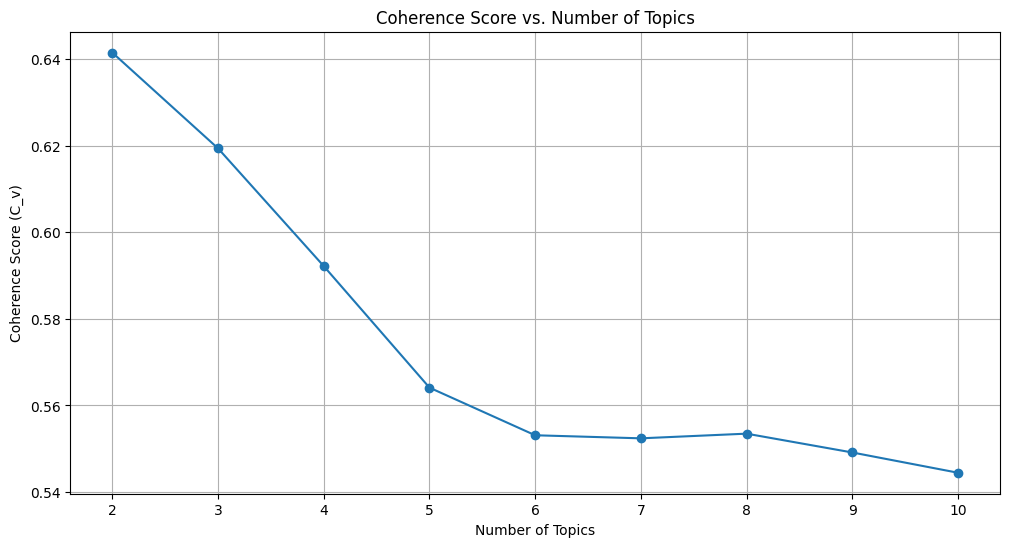

In [103]:
!pip install matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Load the model results from the CSV file
model_results_df = pd.read_csv('../Dataset/lda_tuning_results.csv')

# Filter the results for the 75% Corpus (you can change this if needed)
# filtered_results = model_results_df[model_results_df['Validation_Set'] == '20% Corpus']

# Group the results by the number of topics (Topics) and calculate the mean coherence score
coherence_by_topics = model_results_df.groupby('Topics')['Coherence'].mean()

# Plot the coherence score against the number of topics
plt.figure(figsize=(12, 6))
plt.plot(coherence_by_topics.index, coherence_by_topics.values, marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [104]:
data_topic_3 = model_results_df[model_results_df['Topics'] == 2]
max_coherence = np.array(data_topic_3['Coherence'])
print(max(model_results_df['Coherence']))
#print(max_coherence[4])
#print(np.argmax(max_coherence))

0.723257906711438


##Visualizing the Data


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056858 -0.205850       1        1  45.462014
3      0.136407 -0.045977       2        1  27.352285
1     -0.096871 -0.162289       3        1  23.510672
4     -0.126572  0.177734       4        1   2.377319
0      0.030178  0.236382       5        1   1.297710, topic_info=          Term          Freq         Total Category  logprob  loglift
32        game  10198.000000  10198.000000  Default  30.0000  30.0000
156      money   2159.000000   2159.000000  Default  29.0000  29.0000
40         kid   5662.000000   5662.000000  Default  28.0000  28.0000
74      roblox   2533.000000   2533.000000  Default  27.0000  27.0000
887    pokemon   1597.000000   1597.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
118    exactly      7.460702    242.425592   Topic5  -6.6151   0.8635
2148  downvote      6.608727     61.305415   Topic5  -6.7363   2.1171
177          s      7.188030    223.670992   Topic5  -6.6523   0.9068
2603       dog      6.760512     89.516270   Topic5  -6.7136   1.7612
1670      wear      6.720092    149.891960   Topic5  -6.7196   1.2398

[389 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
468        2  0.979962      aaa
4244       1  0.254801  abusive
4244       2  0.063700  abusive
4244       3  0.254801  abusive
4244       5  0.445902  abusive
...      ...       ...      ...
569        2  0.002487  youtube
569        3  0.099477  youtube
569        4  0.002487  youtube
15146      2  0.199523    youuu
15146      5  0.598569    youuu

[1079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])

In [ ]:
lda_model_tuned = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.9099999999999999,
                                       eta=0.9099999999999999)

In [127]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tuned, corpus, id2word, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.018925  0.296447       1        1  38.915796
5      0.189028  0.152615       2        1  19.842260
6     -0.168326  0.151682       3        1  15.360599
3      0.110527 -0.149857       4        1   6.158249
1      0.041334 -0.041426       5        1   4.861874
2     -0.078881 -0.126914       6        1   3.971197
0     -0.049454 -0.081502       7        1   3.745999
4     -0.020512 -0.105403       8        1   3.717784
7     -0.004792 -0.095641       9        1   3.426242, topic_info=       Term         Freq        Total Category  logprob  loglift
32     game  8936.000000  8936.000000  Default  30.0000  30.0000
156   money  1892.000000  1892.000000  Default  29.0000  29.0000
40      kid  4872.000000  4872.000000  Default  28.0000  28.0000
1253   love  1212.000000  1212.000000  Default  27.0000  27.0000
326    look  1973.000000  1973.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
1970    cry    10.311283    93.249782   Topic9  -7.2623   1.1717
474    mean    17.154264   772.544314   Topic9  -6.7533  -0.4337
252   great    14.643894   835.852136   Topic9  -6.9115  -0.6707
251    good    10.068787  2416.967614   Topic9  -7.2861  -2.1071
94    still     8.543449  1362.048364   Topic9  -7.4504  -1.6979

[480 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
756       1  0.976435  access
756       2  0.002370  access
756       3  0.007110  access
756       4  0.002370  access
756       5  0.002370  access
...     ...       ...     ...
5670      5  0.105142     yup
5670      6  0.105142     yup
5670      7  0.105142     yup
5670      8  0.105142     yup
5670      9  0.420568     yup

[3753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 7, 4, 2, 3, 1, 5, 8])

In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)
print(document_topics)


In [ ]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 1
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')


There are 4412 reviews in topic 1.


In [ ]:
#import pandas as pd
#reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

#mixture = [dict(lda_model[x]) for x in corpus]
pd.DataFrame(reviews_in_topic_1).to_csv("topic_mixture.csv")

In [ ]:
print(max(document_topics))

[(4, 0.9991119)]


In [ ]:
# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 5
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')

There are 0 reviews in topic 5.


In [ ]:
 # The code blocks below output the comments into .csv files!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  

#Preprocessing stuff
datax= load_data('../Used_Dataset/finalCumulative.csv') #Accesses finalCumulative.csv and loads it into the DataFrame called datax
filtered_data = datax.drop(columns=['subreddit','date','timestamp'], axis=1) # Pulls out the 'subreddit', 'date', and 'timestamp' columns from the DataFrame and puts it into filtered_data
datax= filtered_data.replace('\n', ' ', regex=True) # Replaces all newline characters with a space in the 'text' column of the DataFrame
import re

datax= datax.loc[datax.text.str.contains('I am a bot') == False, :] # Removes all rows from the DataFrame that contain the string 'I am a bot' in the 'text' column

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
datax['text'] = datax['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

datax['text'] = datax['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\(', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\)', ' ', x))
datax['text'] = datax['text'].replace(r'&\S+', '', regex=True)
datax['text'] = datax['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
datax['text'] = datax['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
datax['text'] = datax['text'].map(lambda x: re.sub(pattern, ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub(' +', ' ', x))

datax.shape

(22911, 2)

In [ ]:
datax.head(5) #Displays the first 5 rows of the DataFrame datax

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [ ]:
#This block can be skipped  (but i decided to include it because it defines resultx2, which is used in the future blocks)
datax['text'][3]
type(datax['text'][3])

resultx2 = [] #Creates an empty list called resultx2
for d in datax['text']:
  resultx2.append(d)

#resultx2.head[5]

In [ ]:
# Get the comments w/o weird spaces
    
# Get the topic distribution for each document
document_topics = lda_model_tuned.get_document_topics(corpus) #Initially it was lda_model.get_document_topics(corpus), but Natasha changed it to lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1_tuned: #changed this to tuned for the other topics
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Data')


#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [ ]:
print(f"reviews_in_topic_1 = {reviews_in_topic_1}")
print(f"reviews_in_topic_1_tuned = {reviews_in_topic_1_tuned}")

reviews_in_topic_1 = [1, 5, 11, 25, 26, 27, 29, 30, 34, 35, 37, 44, 45, 47, 50, 51, 54, 55, 58, 61, 66, 68, 75, 79, 83, 87, 90, 93, 99, 102, 115, 116, 123, 124, 128, 135, 136, 149, 152, 153, 158, 168, 169, 176, 180, 184, 186, 188, 190, 196, 206, 207, 210, 211, 215, 216, 217, 219, 225, 226, 232, 234, 241, 248, 249, 255, 261, 263, 264, 269, 272, 274, 276, 277, 284, 285, 287, 300, 301, 310, 312, 313, 318, 321, 322, 323, 324, 325, 326, 329, 360, 361, 365, 367, 368, 371, 372, 373, 374, 378, 379, 380, 385, 386, 389, 390, 391, 393, 395, 398, 400, 402, 403, 405, 406, 407, 408, 411, 412, 413, 424, 425, 427, 429, 430, 436, 437, 438, 448, 451, 452, 453, 454, 455, 456, 457, 458, 465, 466, 467, 468, 474, 478, 479, 482, 484, 490, 494, 497, 499, 501, 507, 508, 511, 513, 515, 517, 519, 522, 523, 530, 533, 534, 535, 536, 538, 539, 569, 582, 586, 597, 602, 608, 622, 624, 626, 644, 646, 657, 658, 661, 674, 707, 730, 748, 765, 774, 784, 795, 819, 820, 838, 844, 846, 851, 857, 870, 880, 888, 905, 908, 909,

In [118]:
#CAN BE SKIPPED    
# Get the topic distribution for each document
document_topics = lda_model_tuned.get_document_topics(corpus) #Initially it was lda_model.get_document_topics(corpus), but Natasha changed it to lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic1.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

# Get the number of reviews in topic 3
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')



There are 758 reviews in topic 1.


In [119]:
#Prof Munyaka said the code blocks below may notttt work

# Get the topic distribution for each document
document_topics_tuned = lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
for idx in reviews_in_topic_1_tuned:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

amen
good luck suing multimillion dollar company evidence laws broken experience
soo dumb


obviosuly confused called pay win even though thats im sure want try explain
yeah hop nl nl see im talking joke
perspective saying wrong saying court law difficult place prove things world law good guys win bad guys lose rather present point best back lawyer testimonies alone enough justify large matter large platform end day court decides fate court evidence citations law articles proceed wish good luck
cry


er

thats bit dramatic

prob bob
ok
post copypasta
robloxmoment
yeah
yes
yes
yeah
exactly

vagina
okay


thats illegal
cash grab
commenter joking
hows different sim

im addicerted like


oh exploiter
right
yep
please tell ur joking
hm

malding cause balding
username need joke
js shut fuck
ya know noticed lol guy deserve upvotes
yes
xd
tjat weird
moai stern
yes

lmao

yes
yeah
advertise like sci fi universes like halo star wars theres game thats pay win called project stardust pretty grindy

In [128]:
# Filter reviews that have topic 2 as their main topic
reviews_in_topic_2_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_2_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic2.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_2 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 3
num_reviews_in_topic_2 = len(reviews_in_topic_2)

print(f'There are {num_reviews_in_topic_2} reviews in topic 2.')



There are 611 reviews in topic 2.


Natasha added the code blocks below so that we generate a csv file for each topic (topics 3 through 9 generated below) (previously, we had 2 topics; but now we have 9 topics)

In [121]:

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_3_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_3_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic3.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_3 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

# Get the number of reviews in topic 3
num_reviews_in_topic_3 = len(reviews_in_topic_3)

print(f'There are {num_reviews_in_topic_3} reviews in topic 3.')


There are 554 reviews in topic 3.


In [122]:

# Filter reviews that have topic 4 as their main topic
reviews_in_topic_4_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 3]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_4_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic4.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_4 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 3]

# Get the number of reviews in topic 3
num_reviews_in_topic_4 = len(reviews_in_topic_4)

print(f'There are {num_reviews_in_topic_4} reviews in topic 4.')


There are 789 reviews in topic 4.


In [123]:

# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 4]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_5_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic5.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 4]

# Get the number of reviews in topic 3
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')


There are 295 reviews in topic 5.


In [124]:

# Filter reviews that have topic 6 as their main topic
reviews_in_topic_6_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_6_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic6.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 6 as their main topic
reviews_in_topic_6 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 3
num_reviews_in_topic_6 = len(reviews_in_topic_3)

print(f'There are {num_reviews_in_topic_6} reviews in topic 6.')


There are 554 reviews in topic 6.


In [125]:

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_7_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 6]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_7_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic7.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_7 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 6]

# Get the number of reviews in topic 3
num_reviews_in_topic_7 = len(reviews_in_topic_7)

print(f'There are {num_reviews_in_topic_7} reviews in topic 7.')


There are 3360 reviews in topic 7.


In [126]:

# Filter reviews that have topic 8 as their main topic
reviews_in_topic_8_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 7]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_8_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic8.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 8 as their main topic
reviews_in_topic_8 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 7]

# Get the number of reviews in topic 3
num_reviews_in_topic_8 = len(reviews_in_topic_8)

print(f'There are {num_reviews_in_topic_8} reviews in topic 8.') #THIS SAYS THERE ARE 0 COMMENTS IN TOPIC 8 BUT THERE ARE

PermissionError: [Errno 13] Permission denied: 'Topic8.csv'

In [ ]:

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_9_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 8]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_9_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic9.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_9 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 8]

# Get the number of reviews in topic 9
num_reviews_in_topic_9 = len(reviews_in_topic_9)

print(f'There are {num_reviews_in_topic_9} reviews in topic 9.')


There are 8976 reviews in topic 9.


In [ ]:
for idx, topics in enumerate(document_topics): 
    print(max(topics, key=lambda x: x[1])[0])



8
6
5
5
6
8
6
5
8
5
5
8
6
5
5
5
1
5
5
5
5
5
6
6
5
8
5
6
5
6
8
8
8
1
6
6
8
6
5
8
1
6
2
6
6
6
5
5
5
5
5
6
5
8
6
6
5
8
6
5
5
6
6
6
5
5
6
6
6
2
2
5
5
5
5
6
8
5
5
8
5
5
5
6
5
5
6
6
5
5
8
5
8
6
6
8
6
8
7
8
8
8
6
5
6
5
8
5
8
8
2
6
8
5
8
8
8
5
5
5
5
5
5
6
6
5
5
5
8
5
6
8
8
5
5
6
8
8
8
5
8
6
8
0
2
8
8
5
8
8
5
5
8
6
5
5
8
5
8
5
6
5
8
8
8
5
8
1
6
6
8
8
8
5
5
8
6
5
6
6
6
5
8
5
5
6
6
5
6
1
6
5
5
5
5
8
6
8
7
6
2
8
5
1
8
2
6
6
8
8
6
0
5
5
8
6
6
8
8
6
6
5
5
5
5
6
6
5
5
8
8
0
6
5
6
5
5
5
5
6
5
6
8
5
5
5
5
5
6
6
0
8
5
5
4
8
8
8
8
5
8
8
8
6
8
5
8
5
5
6
5
5
6
8
8
6
8
2
5
8
8
5
8
8
8
8
5
8
5
6
5
0
1
5
6
5
6
1
8
8
8
8
6
8
1
6
5
4
5
5
8
8
6
8
8
5
5
8
8
5
5
8
6
8
8
8
8
8
5
6
5
8
8
5
8
8
5
5
5
6
5
5
8
5
8
5
5
5
5
5
8
0
6
6
5
5
5
5
1
5
6
8
5
5
8
8
5
5
8
8
8
8
8
8
8
8
8
8
6
0
8
5
8
3
8
6
6
8
8
6
6
8
5
6
6
8
0
8
6
6
6
6
6
6
6
6
6
6
6
8
6
6
6
6
8
6
6
8
3
0
2
3
3
5
6
8
5
6
6
6
6
6
5
3
1
8
5
6
6
5
6
8
1
6
6
8
0
8
8
7
8
8
6
6
6
5
6
6
1
2
5
8
8
7
0
6
6
6
6
8
5
5
6
5
6
5
6
8
6
6
6
5
8
6
6
5
5
8
5
5
6
5
5
5
6
3
0
6
0
6
